In [99]:
%matplotlib notebook

from sklearn.tree import DecisionTreeClassifier
import sparsipy

import numpy as np
import matplotlib.pyplot as plt

import copy


class AdaBoost():
    '''
        Only important functions:
            fit
            predict
            sparsify
            minimal_margin
    '''
    def __init__(self, debug=False, plot=False, pre_normalize=False, post_normalize=False):
        self.reset()
        self.debug           = debug
        self.plot            = plot 
        self.pre_normalize   = pre_normalize
        self.post_normalize  = post_normalize
        self.train_margins   = None
        
    def reset(self):
        self.estimators      = []
        self.alphas          = []
        self.sample_weight   = None
    
    def fit(self, X, y, T, plot=None, color='-go'):
        n, d = X.shape
        assert set(y) == {-1, +1}, ("Labels should be {-1, +1} and not ", set(y))
        self.reset()
        
        self.sample_weight = np.ones(n) / n # start with uniform distribution
        margins = self.step_to(X, y, T, plot=plot, color=color)
        
        return margins

    def step(self, X, y):
        # learn weak guy on weighed data set
        h_t  = DecisionTreeClassifier(max_depth=2)
        h_t.fit(X, y, sample_weight=self.sample_weight)
        eps_t = 1 - h_t.score(X, y, sample_weight=self.sample_weight)

        alpha_t = 1/2 * np.log((1-eps_t)/eps_t)

        self.estimators.append(h_t)
        self.alphas.append(alpha_t)

        predictions = h_t.predict(X)
        self.sample_weight = self.sample_weight * np.exp(- alpha_t * y * predictions )
        self.sample_weight = self.sample_weight / np.sum(self.sample_weight)
    
    def step_to(self, X, y, T, plot=None, color='-go', title=None):
        current_hypothesis = len(self.alphas)
        remaining = T - current_hypothesis
        
        # Visualization stuff
        margins = []
        xs = []
        if plot is not None and current_hypothesis != 0: 
            margins.append(self.minimal_margin(X, y))
            xs.append(current_hypothesis)
        
        # adaboost code
        for i in range(remaining): 
            self.step(X, y) 
            
            # Visualization; plot 100 steps
            if plot is not None:
                margins.append(self.minimal_margin(X, y))
                xs.append(len(self.alphas))
                plot[1].plot(xs, margins, color)
                plot[1].set_xlabel("# hypothesis")
                plot[1].set_ylabel("Minimal Margin")
                plot[0].canvas.draw()
                
        self.train_margins = margins
        return margins
        
    def predict_unsigned(self, X):
        n, d = X.shape
        pred = [self.alphas[i]*self.estimators[i].predict(X) for i in range(len(self.estimators))]
        pred = np.sum(pred, axis=0)
        assert pred.shape == (n, ), pred.shape
        return pred
    
    def predict(self, X):
        # np.sign(0)=0, handle this. 
        return np.sign(self.predict_unsigned(X))
    
    # compute the normalized margin!
    def margins(self, X, y):
        pred_unsigned = self.predict_unsigned(X)
        result_margins = pred_unsigned * y / np.sum(self.alphas)
        return result_margins
    
    def minimal_margin(self, X, y):
        return np.min(self.margins(X, y))
    
    def sparsify(self, X, y, target, plot=None, color='bo'):
        '''
        Given data X and labels y, uses discrepancy minimization to
        sparsify the hypothesis gained. How do we select the best one?
        
        Heuristic: take the one closest to 10 hypothesis (later, update this to train
                                                         less than tharget and then closest to target)
        '''
        U = self.compute_matrix(X, y)
        n, T = U.shape
        
        w = self.alphas
        if self.pre_normalize: w = w / np.sum(w)
            
        w = sparsipy.sparsify(U, w, target)
        
        for i in range(len(w)-1, 0, -1):
            current_ada = copy.deepcopy(self)
            non_zero = sum(w[i] != 0)
            if non_zero > 80: break
            
            # find the non-zero entries of w in alpha/estimators. 
            lists = []
            for j in range(w.shape[1]):
                lists.append( (w[i][j], current_ada.estimators[j]) )
            lists = sorted(lists, key = lambda x: x[0], reverse=True)
            
            # add estimators/alphas with positive weight/alpha
            current_ada.estimators = [tupple[1] for tupple in lists if tupple[0] > 0.0] 
            current_ada.alphas     = [tupple[0] for tupple in lists if tupple[0] > 0.0]

            if current_ada.post_normalize == True: 
                current_ada.alphas = list(current_ada.alphas / np.sum(current_ada.alphas))
            elif current_ada.post_normalize == "least_square":
                #current_ada.alphas = current_ada.alphas / np.sum(current_ada.alphas)
                original_w = self.alphas
                c = np.sum( w[i] * original_w) / np.sum(w[i]**2)
                w[i] = w[i] * c  
                w[i] = w[i] / np.sum(w[i])
            
            # update sample weight
            margins = current_ada.margins(X, y)
            current_ada.sample_weight = np.exp(- margins)

            print("")
            
            print("Sparsify %i gave margin: \t"%(non_zero), np.min(margins), "\t(%f)"%self.train_margins[non_zero])
            
            margins = current_ada.step_to(X, y, T, plot=plot, color=color)
            
            print("Train %i -> %i gave margin: \t"%(non_zero, T), margins[-1])            
        
    def compute_matrix(self, X, y): 
        '''
        Compute matrix U such that U_ij = h_j(x_i)
        Notice U will have size n x T
        '''
        T = len(self.alphas)
        n, d = X.shape
        U = np.zeros( (n, T) )
        
        for i in range(T):
            U[:, i] = self.estimators[i].predict(X)
            
        return U
    
    def score(self, X, y):
        n, d = X.shape
        pred = self.predict(X)
        return sum(pred == y) / n

def initialize_experiment(X, y, T):
    ada = AdaBoost(debug=False, pre_normalize=False, post_normalize=False)
    
    fig_ax_tupple = plt.subplots(1, 1, figsize=(10,5)) 
    fig_ax_tupple[1].set_xscale("log")
    
    title = "Initial AdaBoost, T=" + str(T)
    fig_ax_tupple[1].set_title(title)
    
    margins = ada.fit(X, y, T, plot=fig_ax_tupple, color='-g')
    
    return ada, margins
    
# reuse ada to be more fair between experiments. 
def experiment(ada, margins, pre_normalize, post_normalize, T):
    fig_ax_tupple = plt.subplots(1, 1, figsize=(10,5)) 
    fig_ax_tupple[1].set_xscale("log")
    
    title = "pre_normalize: " + str(pre_normalize) + ", post_normalize: " +str(post_normalize) + ", T: " + str(T)
    fig_ax_tupple[1].set_title(title)
    
    fig_ax_tupple[1].plot(range(1, T+1), margins, '-g')

    print("Fit %i directly: \t\t"%T, margins[-1]) 
    ada.sparsify(X, y, 10, plot=fig_ax_tupple, color='-b')
    fig_ax_tupple[0].savefig("figures/" + title)
    fig_ax_tupple[0].canvas.draw()

# Sanity check: compare with SKlearn

In [133]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

X, y = make_classification(1000, 5, n_classes=2)
y = y*2-1

T = 100
sklearn_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),  algorithm="SAMME", n_estimators=T)
sklearn_ada.fit(X, y)

alex_ada = AdaBoost()
alex_ada.fit(X, y, T)

print("Sklearn: \t", sklearn_ada.score(X, y))
print("Alex: \t\t", alex_ada.score(X, y)) 

Sklearn: 	 0.941
Alex: 		 0.941


# Plot minimal margin during fit

<IPython.core.display.Javascript object>


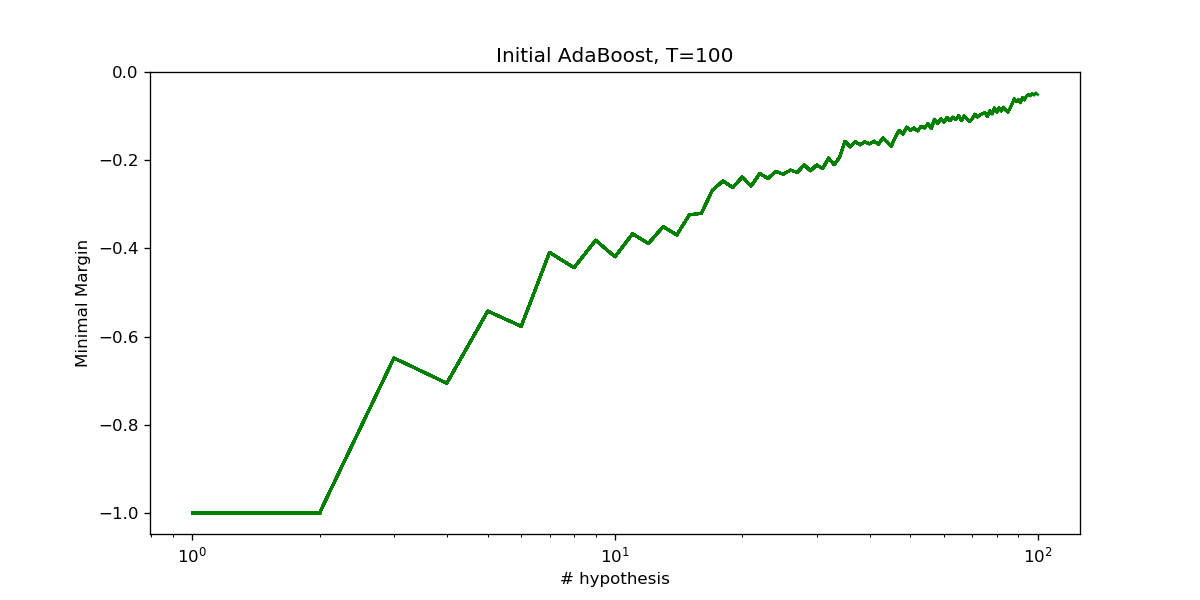

/home/ubudevml/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


In [108]:
from sklearn.datasets import make_classification

X, y = make_classification(1000, 5, n_classes=2)
y = y*2-1
T = 100

alex_ada, margins = initialize_experiment(X, y, T) # init my adaboost with plot, then fit. 

# Simple sparify experiment

<IPython.core.display.Javascript object>


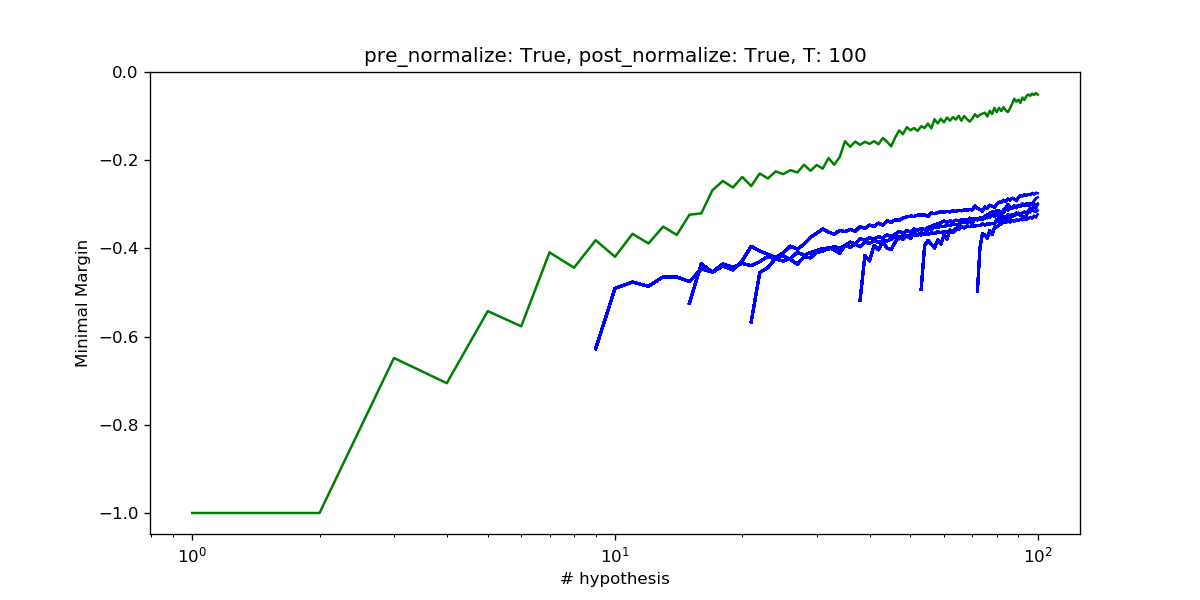

Fit 100 directly: 		 -0.050960083364
Sparsify 9 gave margin: 	 -0.627349558818 	(-0.418824)
Train 9 -> 100 gave margin: 	 -0.297916038187

Sparsify 15 gave margin: 	 -0.524086732845 	(-0.320380)
Train 15 -> 100 gave margin: 	 -0.274684339115

Sparsify 21 gave margin: 	 -0.566348767958 	(-0.229853)
Train 21 -> 100 gave margin: 	 -0.322389092281

Sparsify 38 gave margin: 	 -0.517550330301 	(-0.158064)
Train 38 -> 100 gave margin: 	 -0.313741507544

Sparsify 53 gave margin: 	 -0.492161226566 	(-0.126617)
Train 53 -> 100 gave margin: 	 -0.284015261102

Sparsify 72 gave margin: 	 -0.497586721827 	(-0.096858)
Train 72 -> 100 gave margin: 	 -0.300537481644



In [122]:
T = 100

experiment(ada, margins, True, True, T)

# Big experiment

<IPython.core.display.Javascript object>


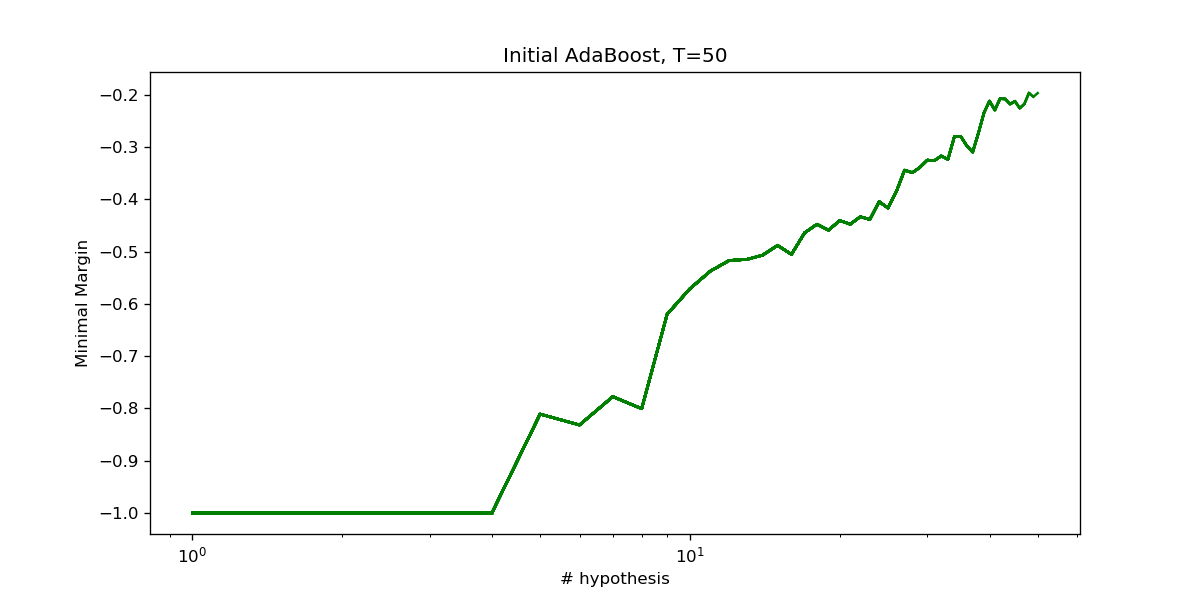

/home/ubudevml/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


<IPython.core.display.Javascript object>


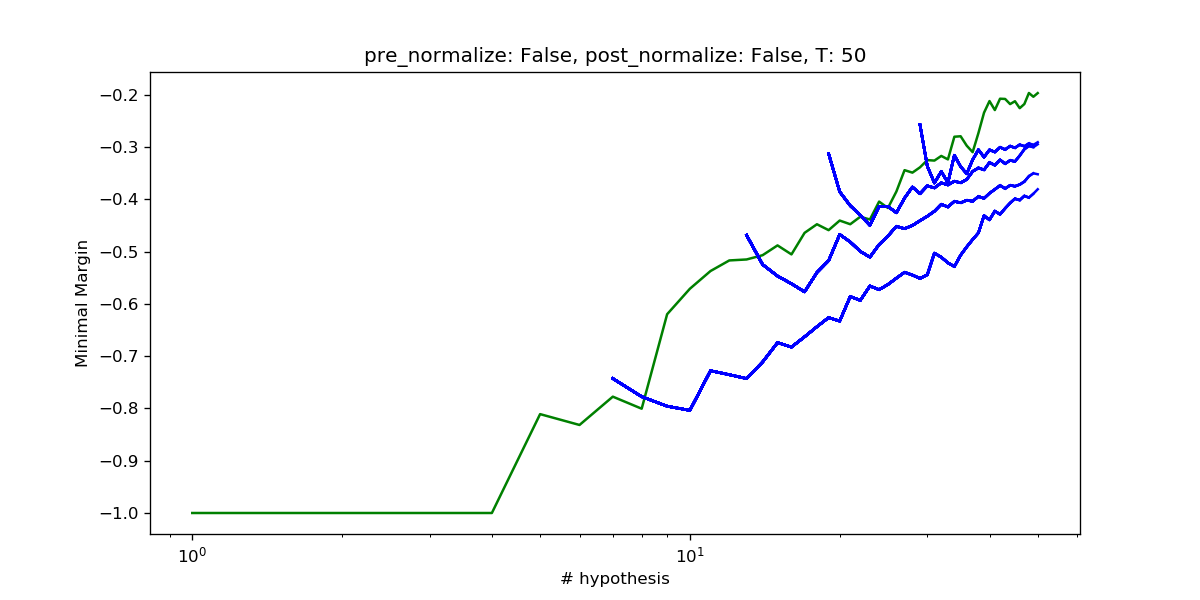

Fit 50 directly: 		 -0.196970973913
Sparsify 7 gave margin: 	 -0.742838921082 	(-0.800553)
Train 7 -> 50 gave margin: 	 -0.380876693334

Sparsify 13 gave margin: 	 -0.468779469552 	(-0.506957)
Train 13 -> 50 gave margin: 	 -0.352204918243

Sparsify 19 gave margin: 	 -0.312765206952 	(-0.440723)
Train 19 -> 50 gave margin: 	 -0.294805930983

Sparsify 29 gave margin: 	 -0.257527477586 	(-0.325154)
Train 29 -> 50 gave margin: 	 -0.290944206121



<IPython.core.display.Javascript object>


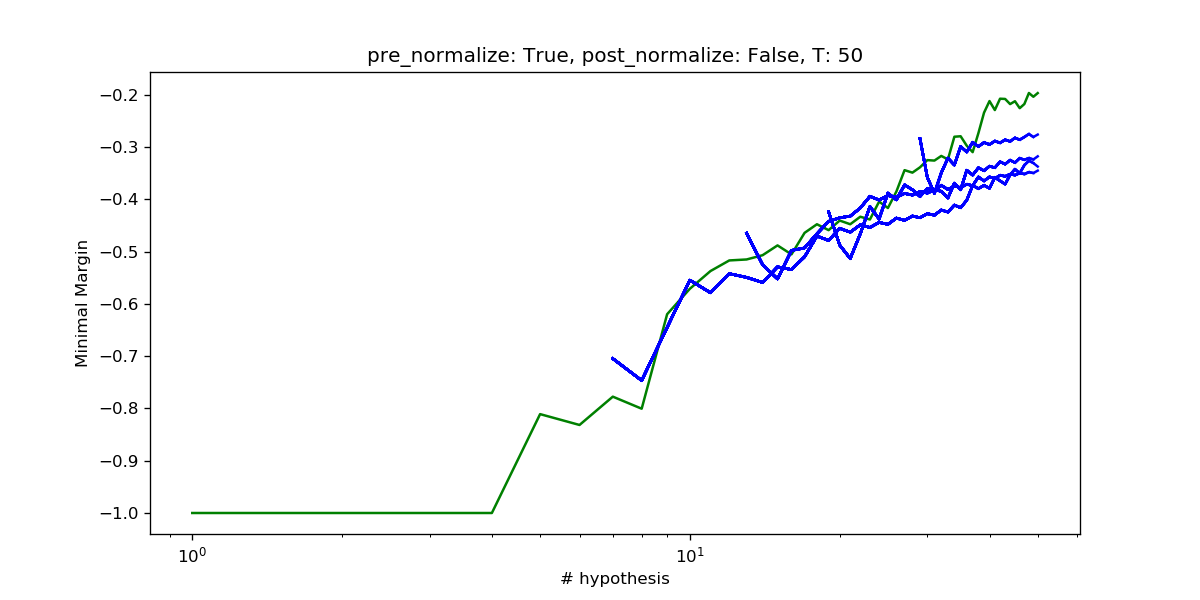

Fit 50 directly: 		 -0.196970973913
Sparsify 7 gave margin: 	 -0.704726124845 	(-0.800553)
Train 7 -> 50 gave margin: 	 -0.337472044269

Sparsify 13 gave margin: 	 -0.464898246997 	(-0.506957)
Train 13 -> 50 gave margin: 	 -0.317919707827

Sparsify 19 gave margin: 	 -0.423953015808 	(-0.440723)
Train 19 -> 50 gave margin: 	 -0.345270110143

Sparsify 29 gave margin: 	 -0.284092927919 	(-0.325154)
Train 29 -> 50 gave margin: 	 -0.276288299805



<IPython.core.display.Javascript object>


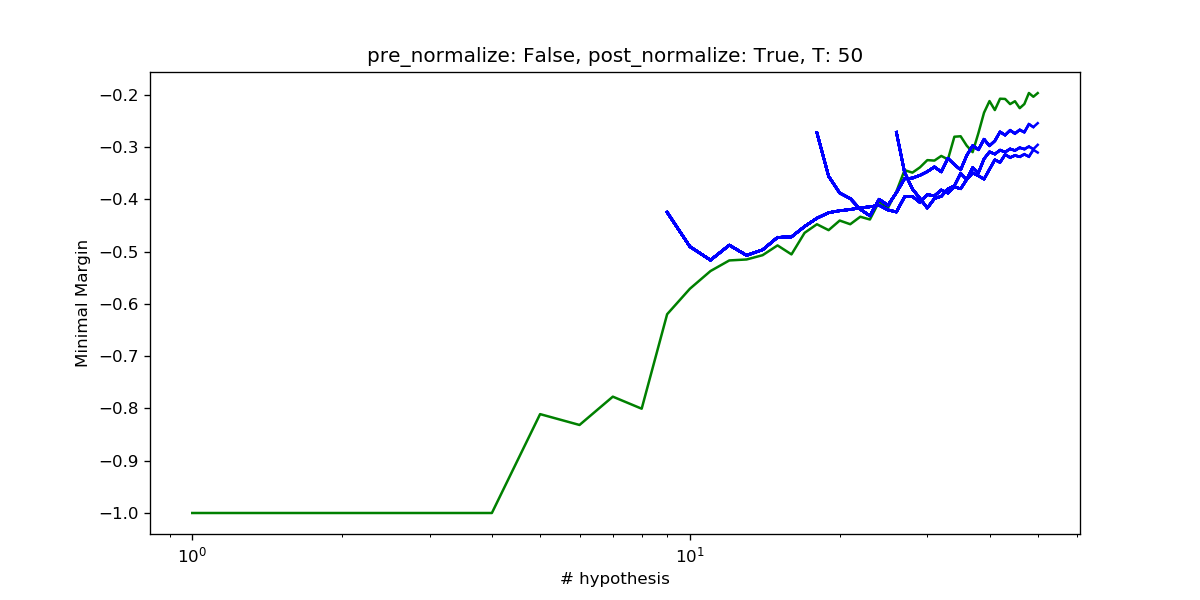

Fit 50 directly: 		 -0.196970973913
Sparsify 9 gave margin: 	 -0.424830439015 	(-0.571113)
Train 9 -> 50 gave margin: 	 -0.310680439187

Sparsify 18 gave margin: 	 -0.272858153923 	(-0.459076)
Train 18 -> 50 gave margin: 	 -0.254499769636

Sparsify 26 gave margin: 	 -0.271951625251 	(-0.344344)
Train 26 -> 50 gave margin: 	 -0.295900830869



<IPython.core.display.Javascript object>


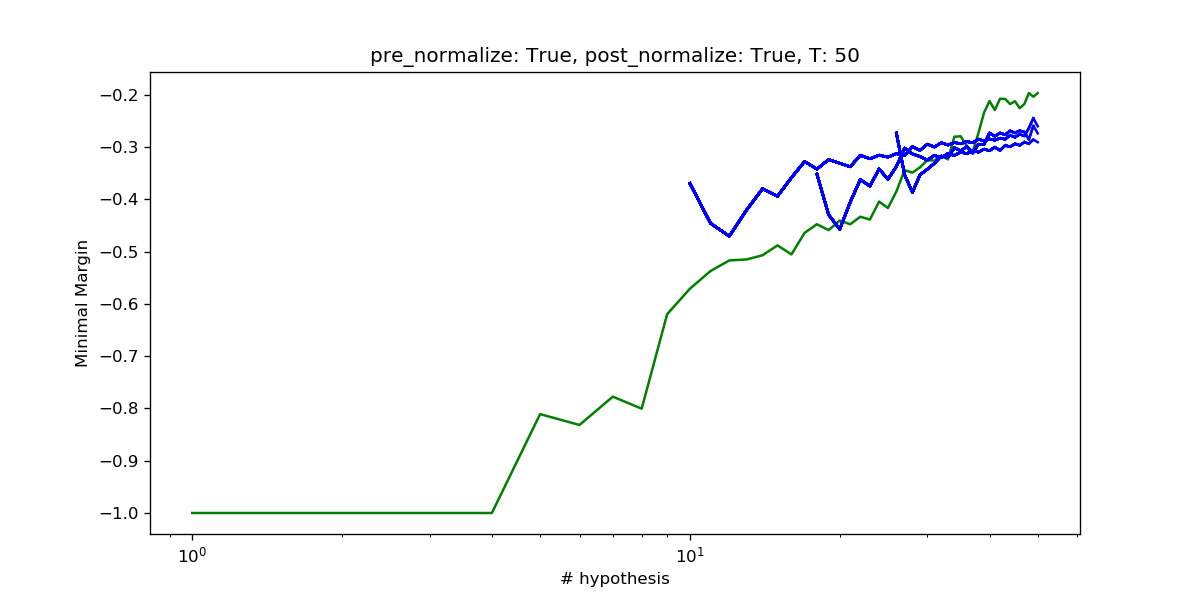

Fit 50 directly: 		 -0.196970973913
Sparsify 10 gave margin: 	 -0.369699686743 	(-0.537284)
Train 10 -> 50 gave margin: 	 -0.260467624656

Sparsify 18 gave margin: 	 -0.351916867966 	(-0.459076)
Train 18 -> 50 gave margin: 	 -0.290938528707

Sparsify 26 gave margin: 	 -0.273449683698 	(-0.344344)
Train 26 -> 50 gave margin: 	 -0.273972284883



<IPython.core.display.Javascript object>


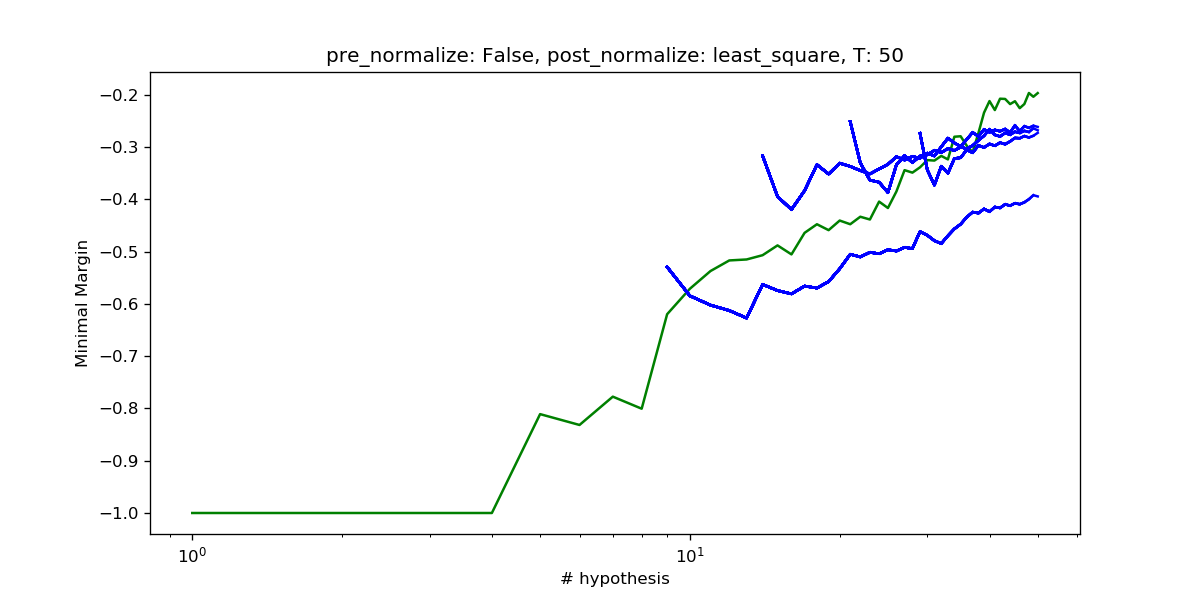

Fit 50 directly: 		 -0.196970973913
Sparsify 9 gave margin: 	 -0.529574620347 	(-0.571113)
Train 9 -> 50 gave margin: 	 -0.394552730504

Sparsify 14 gave margin: 	 -0.316929331303 	(-0.488237)
Train 14 -> 50 gave margin: 	 -0.261614102459

Sparsify 21 gave margin: 	 -0.25168201687 	(-0.433428)
Train 21 -> 50 gave margin: 	 -0.268074967433

Sparsify 29 gave margin: 	 -0.27376184709 	(-0.325154)
Train 29 -> 50 gave margin: 	 -0.273003555677



<IPython.core.display.Javascript object>


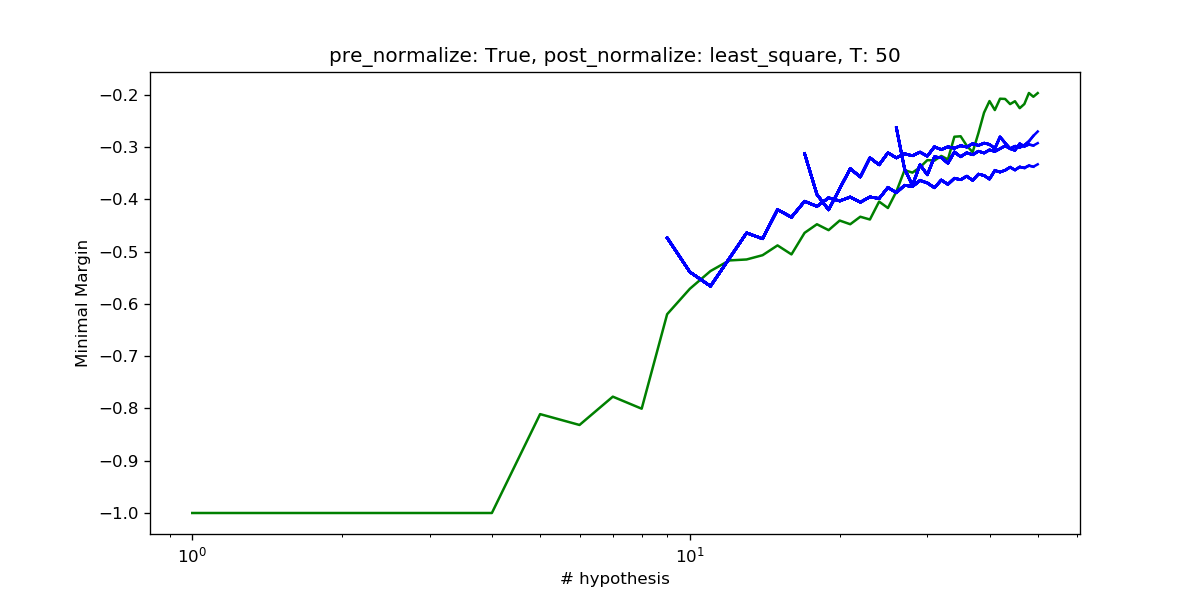

Fit 50 directly: 		 -0.196970973913
Sparsify 9 gave margin: 	 -0.47368686786 	(-0.571113)
Train 9 -> 50 gave margin: 	 -0.333166873784

Sparsify 17 gave margin: 	 -0.312548536292 	(-0.447793)
Train 17 -> 50 gave margin: 	 -0.29268718324

Sparsify 26 gave margin: 	 -0.263572334583 	(-0.344344)
Train 26 -> 50 gave margin: 	 -0.270425455225



In [134]:
T = 50

ada, margins = initialize_experiment(X, y, T)

experiment(ada, margins, False, False, T)
experiment(ada, margins, True, False, T)
experiment(ada, margins, False, True, T)
experiment(ada, margins, True, True, T)
experiment(ada, margins, False, "least_square", T)
experiment(ada, margins, True, "least_square", T)